In [5]:
'''modified delay injection method:
1) Multiprocessing: The multiprocessing.Pool is used to parallelize the latency 
injection process. Each source node is processed in parallel.
2) Parameter List: A list of parameters (params_list) is created to pass to the 
automate_latency_injection function. Each element in the list contains the source node name, 
delay matrix, and node details.
the latency in the matrix.
3) Pool Mapping: The pool.map function is used to apply 
the automate_latency_injection function to each element in params_list in parallel..
'''

'modified delay injection method:\n1) Multiprocessing: The multiprocessing.Pool is used to parallelize the latency \ninjection process. Each source node is processed in parallel.\n2) Parameter List: A list of parameters (params_list) is created to pass to the \nautomate_latency_injection function. Each element in the list contains the source node name, \ndelay matrix, and node details.\nthe latency in the matrix.\n3) Pool Mapping: The pool.map function is used to apply \nthe automate_latency_injection function to each element in params_list in parallel..\n'

In [1]:
'''the code is executed in paralla '''

import random
import csv
import paramiko
from multiprocessing import Pool

# Function to generate a realistic delay matrix
def generate_delay_matrix(num_nodes, base_latency=5, max_additional_latency=50):
    delay_matrix = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                delay_matrix[i][j] = 0 # node-to-node its self, latency set to zero
            else:
                # additional_latency = random.uniform(0, max_additional_latency)
                additional_latency = random.uniform(0, max_additional_latency)
                distance_factor = abs(i - j) / num_nodes
                simulated_latency = base_latency + additional_latency * distance_factor
                congestion_factor = random.uniform(0.5, 1.5)
                delay_matrix[i][j] = int(simulated_latency * congestion_factor) # change the float to integer
    return delay_matrix

# Generate delay matrix for 9 worker nodes
'''Injecting no latencies'''
# delay_matrix = generate_delay_matrix(num_nodes=9, base_latency=0, max_additional_latency=0)

# Generate delay matrix for 9 worker nodes
delay_matrix = generate_delay_matrix(num_nodes=9, base_latency= 5, max_additional_latency= 50)
delay_matrix


'''config notes:
(1) base_latency=0, max_additional_latency=0; QPS =50; average latency = 15ms
(2) base_latency= 5, max_additional_latency= 100; QPS =50; average_latency = 600ms
(3) base_latency= 5, max_additional_latency= 50; QPS =50; average_latency = 300ms

'''

'config notes:\n(1) base_latency=0, max_additional_latency=0; QPS =50; average latency = 15ms\n(2) base_latency= 5, max_additional_latency= 100; QPS =50; average_latency = 600ms\n(3) base_latency= 5, max_additional_latency= 50; QPS =50; average_latency = 300ms\n\n'

In [2]:
delay_matrix

[[0, 6, 12, 20, 6, 20, 21, 36, 15],
 [10, 0, 8, 9, 7, 5, 17, 23, 29],
 [9, 7, 0, 5, 8, 16, 12, 19, 25],
 [6, 7, 6, 0, 4, 4, 23, 12, 7],
 [12, 4, 9, 14, 0, 11, 8, 10, 17],
 [17, 22, 20, 7, 8, 0, 4, 7, 6],
 [10, 25, 6, 12, 19, 8, 0, 7, 11],
 [24, 10, 40, 17, 7, 5, 10, 0, 10],
 [14, 22, 14, 23, 15, 15, 15, 7, 0]]

In [3]:



# Save the delay matrix to a CSV file
with open('delay_matrix2.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(delay_matrix)

def apply_latency_between_nodes(source_node_name, username, key_path, interface, delay_matrix, node_details):
    """Apply latency between source and destination nodes using SSH with a private key."""
    client = paramiko.SSHClient()
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    client.load_system_host_keys()
    
    try:
        source_node_ip = node_details[source_node_name]['ip']
        client.connect(source_node_ip, username=username, key_filename=key_path)
        
        # Clear existing rules:
        client.exec_command(f"sudo tc qdisc del dev {interface} root")
        
        client.exec_command(f"sudo tc qdisc add dev {interface} root handle 1: htb default 1")
        client.exec_command(f"sudo tc class add dev {interface} parent 1: classid 1:1 htb rate 100mbps")
        
        mark_count = 2  # Start from 2 to reserve 1:1 as the default class
        dst_node_details = exclude_src_node(source_node_name, node_details)
        source_node_index = list(node_details.keys()).index(source_node_name)

        for dst_node, details in dst_node_details.items():
            dst_node_index = list(node_details.keys()).index(dst_node)
            dst_node_ip = details['ip']
            latency = delay_matrix[source_node_index][dst_node_index]
            print(dst_node_ip)
            
            command_class_add = f"sudo tc class add dev {interface} parent 1: classid 1:{mark_count} htb rate 100mbps"
            command_delay_add = f"sudo tc qdisc add dev {interface} parent 1:{mark_count} handle {mark_count}0: netem delay {latency}ms"
            command_filter_add = f"sudo tc filter add dev {interface} protocol ip parent 1:0 prio 1 u32 match ip dst {dst_node_ip} flowid 1:{mark_count}"
            
            client.exec_command(command_class_add)
            client.exec_command(command_delay_add)
            client.exec_command(command_filter_add)
            
            print(f'From {source_node_name} to {dst_node}: injected latency {latency} ms ')
            mark_count += 1

    except Exception as e:
        print(f"Failed to apply latency for {source_node_name}: {e}")
    finally:
        client.close()

def exclude_src_node(src_node_name, node_details):
    return {name: details for name, details in node_details.items() if name != src_node_name}

def automate_latency_injection(params):
    source_node_name, delay_matrix, node_details = params
    username = node_details[source_node_name]['username']
    key_path = node_details[source_node_name]['key_path']
    interface = 'eth0'  # Assuming the interface name is eth0
    apply_latency_between_nodes(source_node_name, username, key_path, interface, delay_matrix, node_details)

# Assuming correct IP addresses and no duplication in node keys
node_details = {
    'k8s-worker-1': {'ip': '172.26.128.30', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-2': {'ip': '172.26.132.91', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-3': {'ip': '172.26.133.31', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-4': {'ip': '172.26.132.241', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-5': {'ip': '172.26.132.142', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-6': {'ip': '172.26.133.55', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-7': {'ip': '172.26.130.22', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-8': {'ip': '172.26.130.82', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-9': {'ip': '172.26.133.118', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'}
}

# Apply latency injection using the generated delay matrix with multiprocessing
params_list = [(source_node, delay_matrix, node_details) for source_node in node_details.keys()]

if __name__ == '__main__':
    with Pool(processes=len(node_details)) as pool:
        pool.map(automate_latency_injection, params_list)


172.26.128.30
172.26.128.30
172.26.128.30
From k8s-worker-9 to k8s-worker-1: injected latency 14 ms 
172.26.132.91
172.26.128.30
172.26.128.30
172.26.128.30
From k8s-worker-8 to k8s-worker-1: injected latency 24 ms 
172.26.132.91
From k8s-worker-2 to k8s-worker-1: injected latency 10 ms 
172.26.128.30172.26.133.31

From k8s-worker-9 to k8s-worker-2: injected latency 22 ms 
172.26.133.31
From k8s-worker-7 to k8s-worker-1: injected latency 10 ms 
172.26.132.91
From k8s-worker-4 to k8s-worker-1: injected latency 6 ms 
172.26.132.91
From k8s-worker-3 to k8s-worker-1: injected latency 9 ms 
172.26.132.91
From k8s-worker-8 to k8s-worker-2: injected latency 10 ms 
172.26.133.31
From k8s-worker-2 to k8s-worker-3: injected latency 8 ms 
172.26.132.241
From k8s-worker-5 to k8s-worker-1: injected latency 12 ms 
172.26.132.91
From k8s-worker-9 to k8s-worker-3: injected latency 14 ms 
172.26.132.241
From k8s-worker-7 to k8s-worker-2: injected latency 25 ms 
172.26.133.31
From k8s-worker-4 to k8s-wo

Secsh channel 10 open FAILED: open failed: Connect failed


Failed to apply latency for k8s-worker-1: ChannelException(2, 'Connect failed')


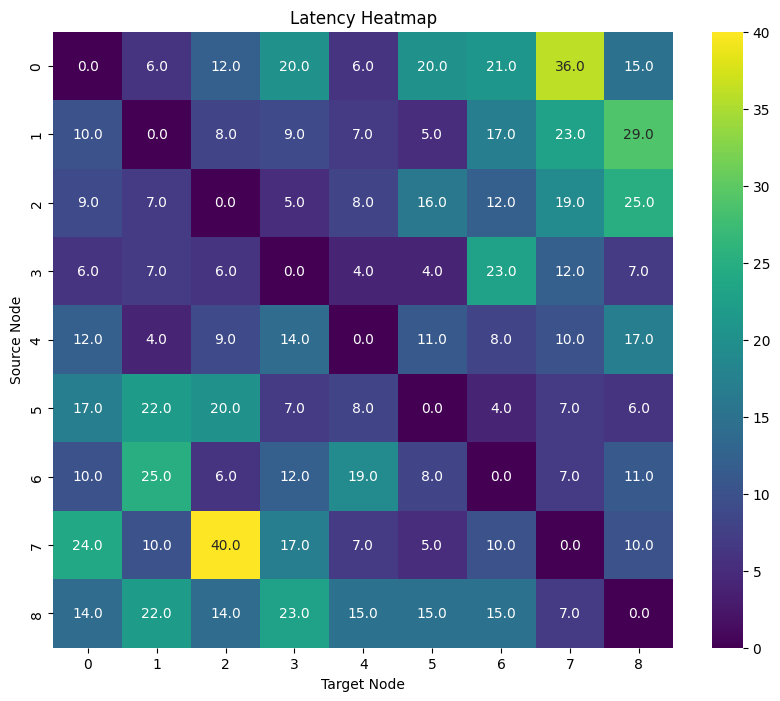

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the delay matrix from the CSV file
delay_matrix = pd.read_csv('delay_matrix2.csv', header=None)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(delay_matrix, annot=True, fmt=".1f", cmap="viridis", cbar=True)
plt.title('Latency Heatmap')
plt.xlabel('Target Node')
plt.ylabel('Source Node')
plt.show()


In [ ]:
'''modified delay injection method:
1) Delay Matrix Generation: The generate_delay_matrix function generates a realistic delay 
matrix considering base latency and additional factors like distance and network congestion.
2) Updated Latency Application: The apply_latency_between_nodes function is modified to 
use the delay matrix values. The source and destination node indices are used to look up 
the latency in the matrix.
3) Automated Latency Injection: The automate_latency_injection function iterates over each 
source node and applies the corresponding latencies to all destination nodes using the delay matrix.
'''

In [1]:
'''the code is executed sequencially'''
import random
import csv
import paramiko

# Function to generate a realistic delay matrix
def generate_delay_matrix(num_nodes, base_latency=2, max_additional_latency=10):
    delay_matrix = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                delay_matrix[i][j] = base_latency
            else:
                additional_latency = random.uniform(0, max_additional_latency)
                distance_factor = abs(i - j) / num_nodes
                simulated_latency = base_latency + additional_latency * distance_factor
                congestion_factor = random.uniform(0.8, 1.2)
                delay_matrix[i][j] = simulated_latency * congestion_factor

    return delay_matrix

# Generate delay matrix for 9 worker nodes
delay_matrix = generate_delay_matrix(num_nodes=9, base_latency= 2, max_additional_latency=200)

# Save the delay matrix to a CSV file
with open('delay_matrix2.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(delay_matrix)

def apply_latency_between_nodes(source_node_name, username, key_path, interface, delay_matrix, node_details):
    """Apply latency between source and destination nodes using SSH with a private key."""
    client = paramiko.SSHClient()
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    client.load_system_host_keys()
    
    try:
        source_node_ip = node_details[source_node_name]['ip']
        client.connect(source_node_ip, username=username, key_filename=key_path)
        
        # Clear existing rules:
        client.exec_command(f"sudo tc qdisc del dev {interface} root")
        client.exec_command(f"sudo tc qdisc add dev {interface} root handle 1: htb default 1")
        client.exec_command(f"sudo tc class add dev {interface} parent 1: classid 1:1 htb rate 100mbps")
        
        mark_count = 2  # Start from 2 to reserve 1:1 as the default class
        dst_node_details = exclude_src_node(source_node_name, node_details)
        source_node_index = list(node_details.keys()).index(source_node_name)

        for dst_node, details in dst_node_details.items():
            dst_node_index = list(node_details.keys()).index(dst_node)
            dst_node_ip = details['ip']
            latency = delay_matrix[source_node_index][dst_node_index]
            print(dst_node_ip)
            
            command_class_add = f"sudo tc class add dev {interface} parent 1: classid 1:{mark_count} htb rate 100mbps"
            command_delay_add = f"sudo tc qdisc add dev {interface} parent 1:{mark_count} handle {mark_count}0: netem delay {latency}ms"
            command_filter_add = f"sudo tc filter add dev {interface} protocol ip parent 1:0 prio 1 u32 match ip dst {dst_node_ip} flowid 1:{mark_count}"
            
            client.exec_command(command_class_add)
            client.exec_command(command_delay_add)
            client.exec_command(command_filter_add)
            
            print(f'From {source_node_name} to {dst_node}: injected latency {latency} ms ')
            mark_count += 1

    except Exception as e:
        print(f"Failed to apply latency for {source_node_name}: {e}")
    finally:
        client.close()

def exclude_src_node(src_node_name, node_details):
    return {name: details for name, details in node_details.items() if name != src_node_name}

def automate_latency_injection(source_node_name, delay_matrix, node_details):
    username = node_details[source_node_name]['username']
    key_path = node_details[source_node_name]['key_path']
    interface = 'eth0'  # Assuming the interface name is eth0
    apply_latency_between_nodes(source_node_name, username, key_path, interface, delay_matrix, node_details)

# Assuming correct IP addresses and no duplication in node keys
node_details = {
    'k8s-worker-1': {'ip': '172.26.128.30', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-2': {'ip': '172.26.132.91', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-3': {'ip': '172.26.133.31', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-4': {'ip': '172.26.132.241', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-5': {'ip': '172.26.132.142', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-6': {'ip': '172.26.133.55', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-7': {'ip': '172.26.130.22', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-8': {'ip': '172.26.130.82', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-9': {'ip': '172.26.133.118', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'}
}

# Apply latency injection using the generated delay matrix
for source_node in node_details.keys():
    automate_latency_injection(source_node, delay_matrix, node_details)


172.26.132.91
From k8s-worker-1 to k8s-worker-2: injected latency 3.4980706984373096 ms 
172.26.133.31
From k8s-worker-1 to k8s-worker-3: injected latency 2.7102470502840292 ms 
172.26.132.241
From k8s-worker-1 to k8s-worker-4: injected latency 2.5469918632969475 ms 
172.26.132.142
From k8s-worker-1 to k8s-worker-5: injected latency 3.2493451391715076 ms 
172.26.133.55
From k8s-worker-1 to k8s-worker-6: injected latency 4.490441301722663 ms 
172.26.130.22
From k8s-worker-1 to k8s-worker-7: injected latency 2.171536899387623 ms 
172.26.130.82
From k8s-worker-1 to k8s-worker-8: injected latency 9.72863840044503 ms 
172.26.133.118
From k8s-worker-1 to k8s-worker-9: injected latency 5.604925967432949 ms 
172.26.128.30
From k8s-worker-2 to k8s-worker-1: injected latency 1.8867612133234495 ms 
172.26.133.31
From k8s-worker-2 to k8s-worker-3: injected latency 2.2449442854985864 ms 
172.26.132.241
From k8s-worker-2 to k8s-worker-4: injected latency 4.184545403778842 ms 
172.26.132.142
From k8s

Secsh channel 10 open FAILED: open failed: Connect failed


From k8s-worker-7 to k8s-worker-2: injected latency 2.6037831209164923 ms 
172.26.133.31
Failed to apply latency for k8s-worker-7: ChannelException(2, 'Connect failed')
172.26.128.30
From k8s-worker-8 to k8s-worker-1: injected latency 6.180990639699206 ms 
172.26.132.91
From k8s-worker-8 to k8s-worker-2: injected latency 2.1190530380856254 ms 
172.26.133.31
From k8s-worker-8 to k8s-worker-3: injected latency 3.281301379571277 ms 
172.26.132.241
From k8s-worker-8 to k8s-worker-4: injected latency 6.849813985524221 ms 
172.26.132.142
From k8s-worker-8 to k8s-worker-5: injected latency 2.5585020995752163 ms 
172.26.133.55
From k8s-worker-8 to k8s-worker-6: injected latency 4.146801971344221 ms 
172.26.130.22
From k8s-worker-8 to k8s-worker-7: injected latency 3.3397396884954107 ms 
172.26.133.118
From k8s-worker-8 to k8s-worker-9: injected latency 3.3473987872132955 ms 
172.26.128.30
From k8s-worker-9 to k8s-worker-1: injected latency 11.03455920903895 ms 
172.26.132.91
From k8s-worker-9 

Secsh channel 14 open FAILED: open failed: Connect failed


From k8s-worker-9 to k8s-worker-3: injected latency 2.6969919650362275 ms 
172.26.132.241
Failed to apply latency for k8s-worker-9: ChannelException(2, 'Connect failed')
